## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

Do it with new testing object.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

Use the code from `diffimTests.py`.

(0.044285781538837568, 17.12840275142554, -74.0, 1713.7774843356319)
(0.15851465540839035, 17.201589327732183, -82.0, 1131.5017745269811)
(300.0442857815388, 17.12840275142554, 226.0, 2013.7774843356319)
(300.1585146554084, 17.201589327732183, 218.0, 1431.5017745269811)


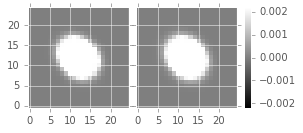

In [13]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varFlux2=1500., 
                         psf1=[1.6,1.6], psf2=[1.8,2.2],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

# Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
P_n = testObj.im2.psf
error = 0.05
ppm = 1. + error
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*ppm, 2.2*ppm], theta=-45.*ppm)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

dit.plotImageGrid((P_n, testObj.im2.psf))

In [14]:
reload(dit)
testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1)
print dit.computeClippedImageStats(testObj.D_AL.im)
D_ZOGY = testObj.doZOGY(inImageSpace=False)
testObj.doZOGY(inImageSpace=True)
print dit.computeClippedImageStats(testObj.D_ZOGY.im)

(-0.0033872859991979868, 0.97876810159324235, -4.6992430803564433, 5.9331857079752748)
(-0.0022570431480845995, 0.98854595024510039, -4.8251665954893141, 6.9509918603943959)


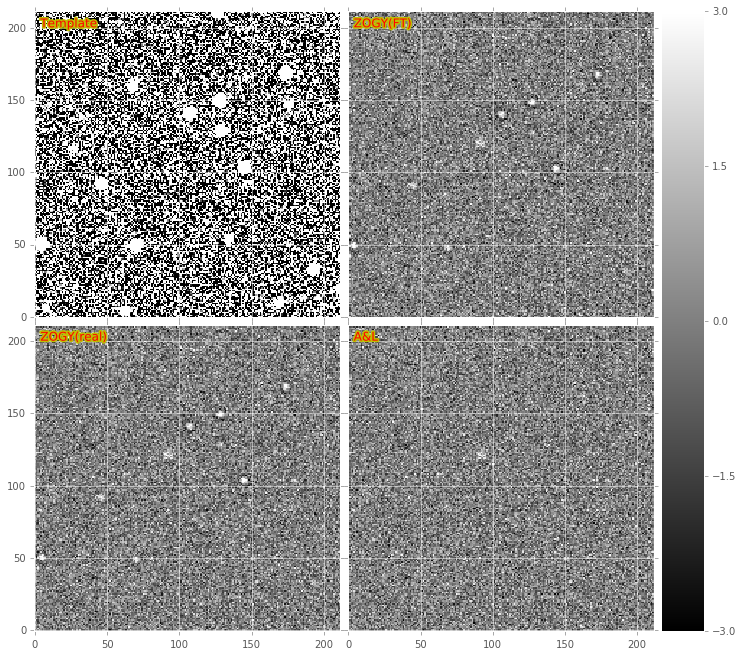

In [15]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (xim.min()+150, xim.max()-150, yim.min()+150, yim.max()-150)
dit.plotImageGrid((testObj.im1.im[x1d:x2d,y1d:y2d], 
                   D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   testObj.D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   testObj.D_AL.im[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY(FT)', 'ZOGY(real)', 'A&L'])

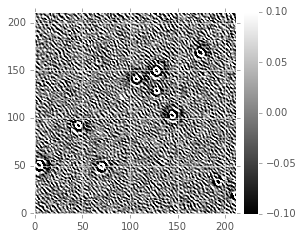

In [27]:
D = testObj.D_ZOGY.im.copy()
D_AL = testObj.D_AL.im.copy()

D[0,:] = D[:,0] = D[-1,:] = D[:,-1] = 0.
D_AL[D == 0] = 0.
fig = plt.figure(1, (4, 4))
dit.plotImageGrid(((D - D_AL)[x1d:x2d,y1d:y2d],), clim=(-0.1, 0.1))

Work on variance planes.

(0.010066064341167087, 0.97866368577195539, -4.5628187805845775, 8.4057325709269666)
(6.8798116980983468e-05, 0.0060997990062276438, -0.028161925383507105, 0.054475199164996942)
[[  242.21750369   271.65070471     0.          1500.        ]] 8.33289061659
28


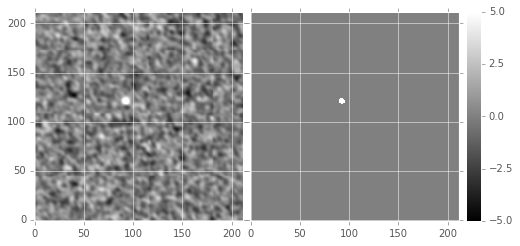

In [28]:
reload(dit);

S_corr, S = testObj.S_corr_ZOGY.im, testObj.S_ZOGY.im
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
changedCentroid = testObj.centroids[testObj.changedCentroidInd, :]
print changedCentroid, S_corr[np.rint(changedCentroid[0,1]).astype(int), np.rint(changedCentroid[0,0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (8, 8))
dit.plotImageGrid((S_corr[x1d:x2d,y1d:y2d], ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)[x1d:x2d,y1d:y2d]), 
                  clim=(-5.,5.))

### Try the reverse case where science is narrower than template...

For A&L, turn on pre-filtering.

In [29]:
reload(dit)
testObj2 = testObj.clone()
testObj2.reverseImages()

testObj2.doZOGY()
dstats_ZOGY = dit.computeClippedImageStats(testObj2.D_ZOGY.im)
print dstats_ZOGY
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doPreConv=False)
print dit.computeClippedImageStats(testObj2.D_AL.im)
D_AL = testObj2.D_AL  # save the non-preconv-ed version
D_kappa = testObj2.kappa_AL
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doDecorr=False, doPreConv=True)
print dit.computeClippedImageStats(testObj2.D_AL.im)
D_AL_noDecorr = testObj2.D_AL  # save the non-preconv-ed version
D_kappa_noDecorr = testObj2.kappa_AL
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doPreConv=True)
print dit.computeClippedImageStats(testObj2.D_AL.im)

(0.00089151092958820836, 0.98660977458560706, -4.4549991823242419, 4.8673302208530771)
(-0.0039878274075037896, 0.95958742483728021, -6.9823506848962653, 18.352723238625849)
(-0.0028363941098776798, 0.76187998625141762, -7.159284565140374, 19.819411907208149)
(-0.00042048201906021458, 0.18021064913464047, -1.4977000827164253, 2.6167777200377196)


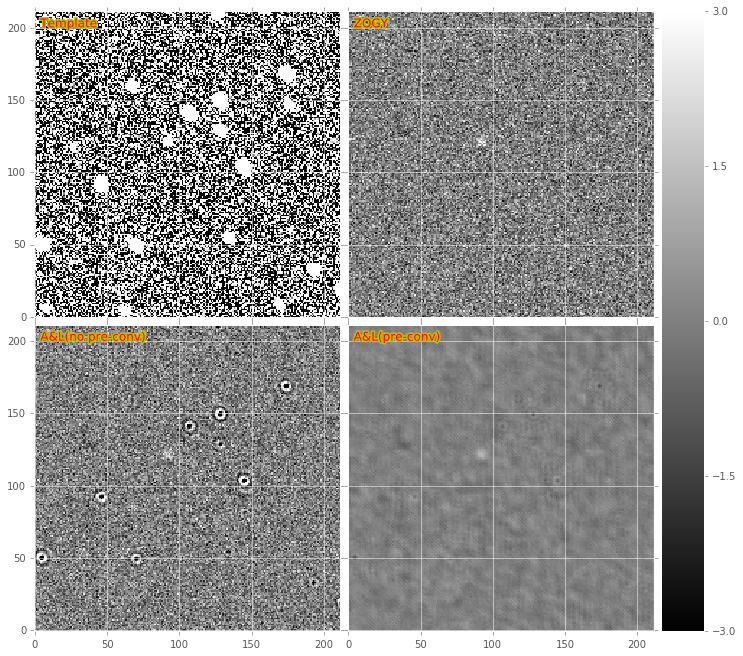

In [30]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj2.im1.im[x1d:x2d,y1d:y2d], -testObj2.D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   -D_AL.im[x1d:x2d,y1d:y2d], -testObj2.D_AL.im[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'A&L(no pre-conv)', 'A&L(pre-conv)'])

(-0.00042048201906021458, 0.18021064913464047, -1.4977000827164253, 2.6167777200377196)
(0.0083037797968382558, 0.62318076741637873, -3.6203941642255666, 14.354267377761884)
103


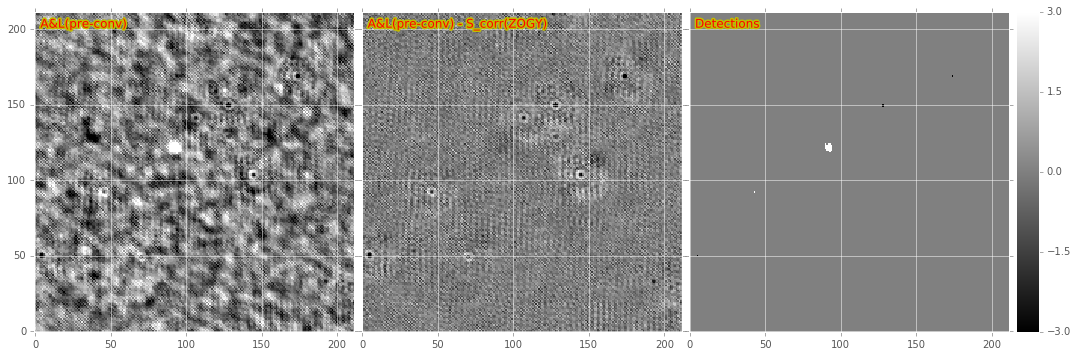

In [31]:
dstats = dit.computeClippedImageStats(testObj2.D_AL.im)
print dstats
#D_AL_pc_ALZC /= 3.0
tmp = (testObj2.D_AL.im - dstats[0]) / dstats[1]
print dit.computeClippedImageStats(tmp-testObj2.S_corr_ZOGY.im)
print (tmp > 5.).sum() + (tmp < -5.).sum()
fig = plt.figure(1, (18, 18))
dit.plotImageGrid((-tmp[x1d:x2d,y1d:y2d], -(tmp-testObj2.S_corr_ZOGY.im)[x1d:x2d,y1d:y2d], 
                   ((tmp > 5.)*-5. + (tmp < -5.)*5.)[x1d:x2d,y1d:y2d]), clim=(-3., 3.),
                 titles=['A&L(pre-conv)', 'A&L(pre-conv) - S_corr(ZOGY)', 'Detections'])

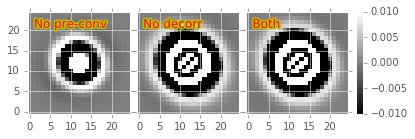

In [32]:
dit.plotImageGrid((D_kappa, D_kappa_noDecorr, testObj2.kappa_AL), titles=['No pre-conv', 'No decorr', 'Both'], 
                  clim=(-0.01,0.01))

## Do it in the stack!

In [10]:
reload(dit)

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varFlux2=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
testObj.doZOGY()
D = testObj.D_ZOGY.im.copy()
testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, kernelSize=15)
D_AL = testObj.D_AL.im.copy()

(300.0442857815388, 17.12840275142554, 226.0, 2013.7774843356319)
(-0.0011009385128495893, 0.98166657424539727, -4.8673302208530771, 4.4549991823242419)
(-0.0036267985108985215, 0.97461030518715053, -4.7006962225983591, 5.9440706711452229)
(0.061390296, 24.063908, -112.54544, 105.41824)
(0.002506248, 0.98240495, -4.5946484, 4.3036814)

(0.0013915014914754613, 0.086128086065360085, -0.97032134051197971, 2.6030741911830972)
(-0.002695416953310797, 0.094139698432695151, -1.9513083483600144, 4.9735931012315895)
(-0.0052287452547716187, 0.055359241046259597, -1.1219725476075433, 3.6244781007914249)


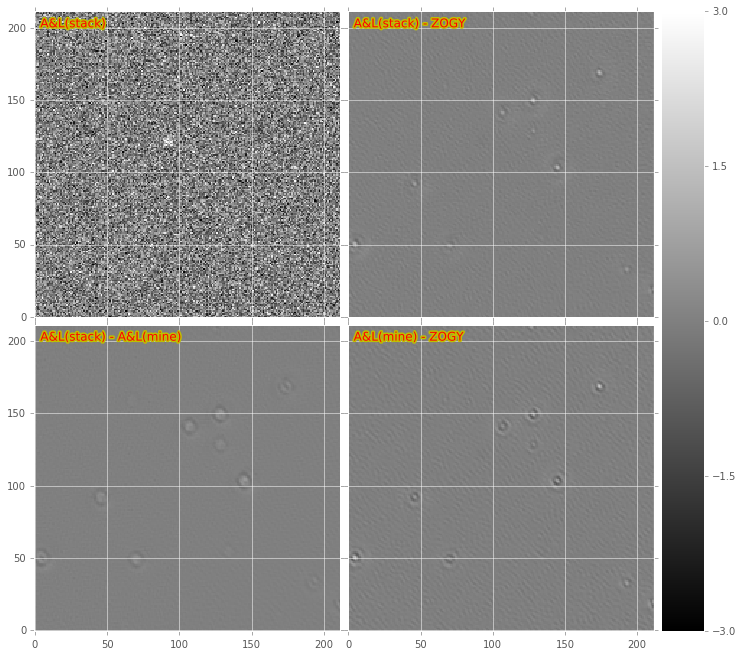

In [11]:
D[0,:] = D[:,0] = D[-1,:] = D[:,-1] = 0.
D_AL[D == 0] = 0.

result = testObj.doALInStack(doDecorr=True)
D_stack = result.decorrelatedDiffim.getMaskedImage().getImage().getArray()

print dit.computeClippedImageStats(testObj.im1.var)
tmp = result.matchedExposure.getMaskedImage().getVariance().getArray()
tmp[(D == 0) | np.isnan(tmp) | np.isinf(tmp)] = np.nan
var2 = dit.computeClippedImageStats(tmp)[0]
D_stack[(D == 0) | np.isnan(D_stack)] = np.nan

# D_stack is shifted again, so unshift it.
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_AL)
print dit.computeClippedImageStats(D_stack)
D_stack /= np.sqrt(testObj.im1.metaData['sky'] + testObj.im1.metaData['sky'])
print dit.computeClippedImageStats(D_stack)
print ""
print dit.computeClippedImageStats(D_stack-D)
print dit.computeClippedImageStats(D_AL-D)
print dit.computeClippedImageStats(D_AL-D_stack)
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((D_stack[x1d:x2d,y1d:y2d], (D_stack-D)[x1d:x2d,y1d:y2d], 
                (D_stack-D_AL)[x1d:x2d,y1d:y2d], (D_AL-D)[x1d:x2d,y1d:y2d]), 
                  titles=['A&L(stack)', 'A&L(stack) - ZOGY', 'A&L(stack) - A&L(mine)' ,'A&L(mine) - ZOGY'], 
                  clim=(-3,3))

Reverse the template and science image. Pre-convolution and decorrelation? Need to implement them myself since right now they are part of pipe_tasks, not ip_diffim.

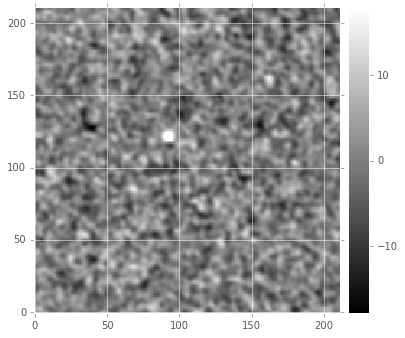

In [12]:
testObj2 = testObj.clone()
testObj2.reverseImages()
result = testObj2.doALInStack(doPreConv=True, doDecorr=False)

fig = plt.figure(1, (6, 6))
dit.plotImageGrid((-result.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],))

In [19]:
reload(dit)

testObj2 = testObj.clone()
testObj2.reverseImages()
result = testObj2.doALInStack(doPreConv=True, doDecorr=True)

(21, 21) (21, 21)


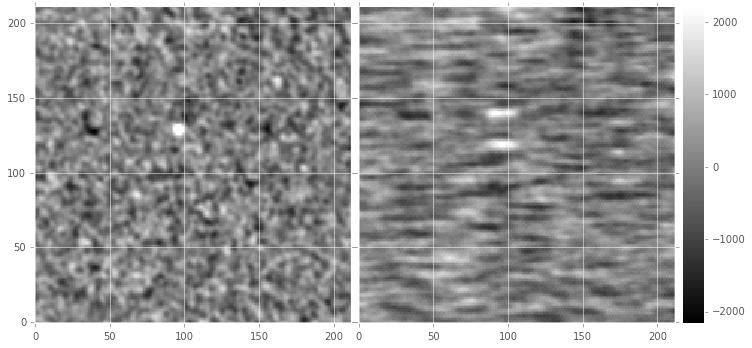

In [20]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-result.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],
                   -result.decorrelatedDiffim.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d]))

# TIMINGS

In [17]:
reload(dit)
testObj = dit.DiffimTest(imSize=(2048,2048), sky=sky, offset=[0,0], psf_yvary_factor=0., varFlux2=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=250, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

In [18]:
%timeit result = testObj.doALInStack(doPreConv=True, doDecorr=False)

1 loop, best of 3: 30.7 s per loop


In [19]:
%timeit result = testObj.doALInStack(doPreConv=False, doDecorr=True)

1 loop, best of 3: 26.1 s per loop


In [20]:
%timeit result = testObj.doALInStack(doPreConv=False, doDecorr=False)

1 loop, best of 3: 19.1 s per loop


In [21]:
%timeit result = testObj.doZOGY(computeScorr=False)

1 loop, best of 3: 14.8 s per loop


In [22]:
%timeit result = testObj.doZOGY(computeScorr=True)

1 loop, best of 3: 21.2 s per loop


In [23]:
%timeit result = testObj.doZOGY(computeScorr=False, inImageSpace=False)

1 loop, best of 3: 2.3 s per loop


In [24]:
%timeit result = testObj.doZOGY(computeScorr=True, inImageSpace=False)

1 loop, best of 3: 8.69 s per loop


In [25]:
%timeit result = testObj.doAL(doPreConv=True)

1 loop, best of 3: 8min 7s per loop


In [26]:
%timeit result = testObj.doAL(doPreConv=False)

1 loop, best of 3: 7min 22s per loop


## See if A&L gets slower with 10x more sources?

In [27]:
reload(dit)
testObj = dit.DiffimTest(imSize=(2048,2048), sky=sky, offset=[0,0], psf_yvary_factor=0., varFlux2=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=2500, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
%timeit result = testObj.doALInStack(doPreConv=False, doDecorr=True)

1 loop, best of 3: 43.2 s per loop


# Now let's take a look at the astrometric error term in ZOGY (eqs. 30-33).

Now computed by default. Let's try a version where we force it NOT to be used, as well.

In [11]:
reload(dit)
testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0.3,0.3], psf_yvary_factor=0., varFlux2=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=250, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
testObj2 = testObj.clone()
testObj2.astrometricOffsets = [0,0]  # override the value so it's not corrected for.
testObj.doZOGY(computeScorr=True)
testObj2.doZOGY(computeScorr=True)

(0.0074759909865170122, 0.94123623279169266, -4.5457334685768167, 7.8232971432137299)
(4.8269186745164899e-05, 0.006555946721147894, -0.1541850141890293, 0.16038541443778376)
[[  253.54128749   253.79769674     0.          1500.        ]] 7.82329714321
14
(0.0065998418471542144, 1.0628613441496009, -15.42580094094933, 15.7745721315124)
(4.8269186745164899e-05, 0.006555946721147894, -0.1541850141890293, 0.16038541443778376)
[[  253.54128749   253.79769674     0.          1500.        ]] 7.87062180324
7353


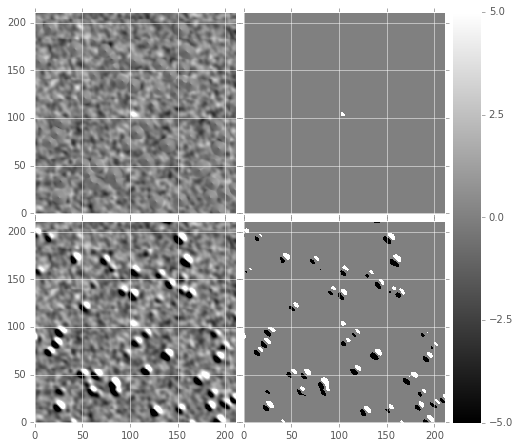

In [12]:
S_corr, S = testObj.S_corr_ZOGY.im, testObj.S_ZOGY.im
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
changedCentroid = testObj.centroids[testObj.changedCentroidInd, :]
print changedCentroid, S_corr[np.rint(changedCentroid[0,1]).astype(int), np.rint(changedCentroid[0,0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()

S_corr2, S2 = testObj2.S_corr_ZOGY.im, testObj2.S_ZOGY.im
print dit.computeClippedImageStats(S_corr2)
print dit.computeClippedImageStats(S2)
changedCentroid = testObj2.centroids[testObj2.changedCentroidInd, :]
print changedCentroid, S_corr2[np.rint(changedCentroid[0,1]).astype(int), np.rint(changedCentroid[0,0]).astype(int)]
print (S_corr2 > 5.).sum() + (S_corr2 < -5.).sum()


fig = plt.figure(1, (8, 8))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
dit.plotImageGrid((S_corr[x1d:x2d,y1d:y2d], ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)[x1d:x2d,y1d:y2d],
                   S_corr2[x1d:x2d,y1d:y2d], ((S_corr2 > 5.)*5.0 + (S_corr2 < -5.)*-5.0)[x1d:x2d,y1d:y2d]),
                  clim=(-5.,5.))